In [1]:
!pip install pmdarima

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import copy
import time
import psutil
import math
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.metrics import smape
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
import psutil

In [3]:
class SymmetricMeanAbsolutePercentageErrorLoss():
    def __call__(self, y_pred, y):
        y_true = y.reshape(y_pred.shape)
        
        return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    
sMAPE = SymmetricMeanAbsolutePercentageErrorLoss()

class Forecast():
    def __call__(self, model, periods): 
        fc, conf_int = model.predict(n_periods=periods, return_conf_int=True)
    
        return (fc.tolist(), np.asarray(conf_int).tolist())
    
forecast = Forecast()

# for CPU profiling
p = psutil.Process()

(604800, 1)
        logEventCount
second               
0                 154
1                 213
2                 351
3                 114
4                 139


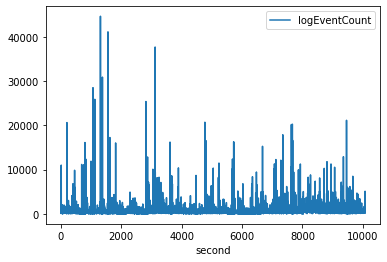

In [4]:
file = 'google_cluster_usage_traces_7D_1S.csv'
df = read_csv(file, sep='|', index_col=[0])
print(df.shape)
#df = df[np.arange(len(df)) % 60 == 0]
df = df[:10080]
print(df.head())
df.plot()
pyplot.show()

In [5]:
# create file with headers for results
results_file_path = f'arima_traces_CPU_sample_rate_1S_{time.time()}_results.csv'
f = open(results_file_path,'a+')
f.write(f"interval|f_length|p_number|s_number|mse|smape|gpu|util|duration\n")

64

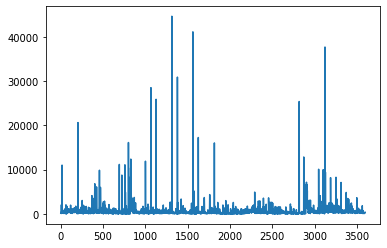

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64365.945, Time=3.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64418.434, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64392.146, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64396.118, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64805.847, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=64380.451, Time=0.94 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=64381.151, Time=1.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=64365.352, Time=4.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=64376.473, Time=0.99 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=64362.705, Time=5.52 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=64370.837, Time=1.07 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=64359.418, Time=2.71 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=64358.237, Time=1.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=64356.528, Time=0.71 sec
 ARIMA(4,0,0)(0,0,0

In [6]:
logEvent_count = df['logEventCount'].tolist()

# global config values, window size, tracker for current offset and max prediction length
w_size = 3600
offset = 3600
f_max = 900
sample_rate = 1

# training and test sets
y_train = logEvent_count[:offset]
y_test = logEvent_count[offset:offset + f_max]

train = pd.Series(y_train)
train.plot()
pyplot.show()

meta = []

# train and append the model
start_time = time.time()
p.cpu_percent(interval=None)
model = pm.auto_arima(y_train, seasonal=True, stepwise=True,
                      suppress_warnings=True, error_action="ignore",
                      max_order=None, trace=True)
util = (p.cpu_percent(interval=None) / psutil.cpu_count()) / 100
end_time = time.time()

# calculate duration based on sample rate, always at least 1
duration = math.ceil((end_time - start_time) / sample_rate) 

# update meta information: model, time of last model update, time when model updates is finished, number of observations
meta.append(model)
meta.append(offset)
meta.append(offset + duration)
meta.append(duration)

# update offset with duration 
offset += duration

interval_meta = dict.fromkeys([300, 900, 1800, 2700, 3600, math.inf])

# deep copy models for all interval lengths and update meta
for interval in interval_meta:
    
    temp = copy.deepcopy(meta)
    temp.append(offset + interval)
    temp.append(None)
    temp.append(None)
    temp.append(None)
    interval_meta[interval] = temp
    
    f.write(f"{interval}|{-1}|{offset}|{offset}|{-1}|{-1}|{0}|{util}|{end_time - start_time}|\n")
    #print(f"{interval}|{-1}|{offset}|{offset}|{-1}|{-1}|{0}|{util}|{end_time - start_time}|{interval_meta[interval]}\n")
    
# calculate number of observations based on sample rate
observations_count = math.floor((end_time - start_time) / sample_rate)

start_time = time.time()
p.cpu_percent(interval=None)

if observations_count != 0:
    # retrieve observations
    observations = logEvent_count[offset:offset + observations_count]
    # update the model with latest observations
    model.update(observations)
    
# create forcast of maximum length
fc = forecast(model, f_max)[0]
util = (p.cpu_percent(interval=None) / psutil.cpu_count()) / 100
end_time = time.time()

# calculate duration based on sample rate, always at least 1
duration = math.ceil((end_time - start_time) / sample_rate) 
    
# evaluate forecast lengths by interval and write to file
for interval in interval_meta:    

    # update meta information, set next forecast and reset number of observations to 0
    interval_meta[interval][2] = interval_meta[interval][2] + duration
    interval_meta[interval][3] = 0
    
    for f_length in np.arange(90,990,90):

        mse_val = mean_squared_error(y_test[:f_length], fc[:f_length])
        smape_val = sMAPE(np.array(y_test[:f_length]), np.array(fc[:f_length]))

        # plot actual and expected graphs
        #act = pd.Series(y_test[:f_length])
        #act.plot()
        #fcs = pd.Series(fc[:f_length])
        #fcs.plot()
        #pyplot.show()

        f.write(f"{interval}|{f_length}|{interval_meta[interval][1]}|{offset}|{mse_val}|{smape_val}|{0}|{util}|{end_time - start_time}\n")
        #print(f"{interval}|{f_length}|{interval_meta[interval][1]}|{offset}|{mse_val}|{smape_val}|{0}|{util}|{end_time - start_time}|{interval_meta[interval]}\n")

In [7]:
interval_meta_copy = copy.deepcopy(interval_meta)

In [ ]:
for i in range(offset, len(logEvent_count)):
               
    # test if enough datapoints exist for forecast
    if f_max > (len(logEvent_count) - i):
        break

    for interval in interval_meta_copy:

        # test if new model is available
        if (i == interval_meta_copy[interval][6]):
            interval_meta_copy[interval][0] = copy.deepcopy(interval_meta_copy[interval][5])
            interval_meta_copy[interval][5] = None
            interval_meta_copy[interval][1] = interval_meta_copy[interval][6]
            interval_meta_copy[interval][6] = None
            interval_meta_copy[interval][3] = interval_meta_copy[interval][7]
            interval_meta_copy[interval][7] = None

        # test if model needs to be updated
        if (i == interval_meta_copy[interval][4]):

            # retrieve training data for current window
            y_train = logEvent_count[i-w_size:i]

            # train new model
            start_time = time.time()
            p.cpu_percent(interval=None)
            model = pm.auto_arima(y_train, seasonal=True, stepwise=True,
                                  suppress_warnings=True, error_action="ignore",
                                  max_order=None, trace=False)
            util = (p.cpu_percent(interval=None) / psutil.cpu_count()) / 100
            end_time = time.time()
            
            # calculate duration based on sample rate, always at least 1
            duration = math.ceil((end_time - start_time) / sample_rate) 

            # update meta information with next model info
            interval_meta_copy[interval][4] += interval  
            interval_meta_copy[interval][5] = copy.deepcopy(model)
            interval_meta_copy[interval][6] = interval_meta_copy[interval][2] + duration
            interval_meta_copy[interval][7] = duration

            f.write(f"{interval}|{-1}|{i}|{i}|{-1}|{-1}|{0}|{util}|{end_time - start_time}|\n")
            #print(f"{interval}|{-1}|{i}|{i}|{-1}|{-1}|{0}|{util}|{end_time - start_time}|\n")

        # test if forecast can be performed this interation
        if (i == interval_meta_copy[interval][2]):

            # perform update with observations and execute forecast
            observations = logEvent_count[i-interval_meta_copy[interval][3]:i]
            
            start_time = time.time()
            p.cpu_percent(interval=None)
            
            if len(observations) != 0:
                # update the model with latest observations
                model.update(observations)
                
            # create forecast of maximum length
            fc = forecast(model, f_max)[0]
            util = (p.cpu_percent(interval=None) / psutil.cpu_count()) / 100
            end_time = time.time()
            
            # calculate duration based on sample rate, always at least 1
            duration = math.ceil((end_time - start_time) / sample_rate) 

            # update meta information, set next forecast
            interval_meta_copy[interval][2] = interval_meta_copy[interval][2] + duration

            y_test = logEvent_count[i:i + f_max]

            # loop through forecast lengths and evaluate       
            for f_length in np.arange(90,990,90):

                mse_val = mean_squared_error(y_test[:f_length], fc[:f_length])
                smape_val = sMAPE(np.array(y_test[:f_length]), np.array(fc[:f_length]))

                f.write(f"{interval}|{f_length}|{interval_meta_copy[interval][1]}|{i}|{mse_val}|{smape_val}|{0}|{util}|{end_time - start_time}\n")
                #print(f"{interval}|{f_length}|{interval_meta_copy[interval][1]}|{i}|{mse_val}|{smape_val}|{0}|{util}|{end_time - start_time}|{interval_meta_copy[interval]}\n")

            # reset number of observations
            interval_meta_copy[interval][3] = duration

        else:

            # increment observations while system is busy
            interval_meta_copy[interval][3] += 1
            

In [ ]:
f.close()

In [ ]:
# TODO check number of observations for new models & check p_number is correctly updated & check model finish number